In [1]:
import numpy as np
from math import *
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams.update({'font.size': 10})

#Hugo Code
import Utility
import PythonKEX 


# ipywidgets for some interactive plots
from ipywidgets.widgets import * 
import ipywidgets as widgets

In [2]:
LM_paths, sino_paths, title, recon_paths = PythonKEX.define_KEX_dataset(isKanyl=False,TOF=True, recon_str="OP")
print(sino_paths)

['C:/Users/petct/Desktop/CylinderPET-Converted/CylinderPET-LM-00/CylinderPET-LM-00-sino-0.s', 'C:/Users/petct/Desktop/CylinderPET-Converted/CylinderPET-LM-01/CylinderPET-LM-01-sino-0.s']


In [3]:
sinogram_1D = []
sinogram_4D = []
for k, s_path in enumerate(sino_paths):
    with open(s_path, "rb") as file:
        sinogram_1D.append(np.fromfile(file, dtype=np.uint16))
        sinogram_4D.append(np.reshape(sinogram_1D[k], Utility.HISTOGRAM_SHAPE))

In [4]:
mi_widget = widgets.IntSlider(
    value=50,
    min=0,
    max=Utility.NUMBER_OF_SINOGRAMS-1,
    step=1,
    description='Michelgram index:',
    disabled=False,
    continuous_update=True,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)

def sinogramPlot(mi):
    plot_scale = 5
    plt.figure(figsize=(plot_scale*len(sino_paths)*1.3,plot_scale))
    tof = 0
    for k in range(0, len(sino_paths)):
        plt.subplot(1,len(sino_paths),k+1)
        plt.imshow(sinogram_4D[k][tof,mi,:,:])
        plt.xlabel(Utility.HISTOGRAM_DIMENSION_TITLES[3])
        plt.ylabel(Utility.HISTOGRAM_DIMENSION_TITLES[2])
        plt.title(sino_paths[k].split('/')[-1] + " at " +
                  Utility.HISTOGRAM_DIMENSION_TITLES[0] + str(tof) + ", " + 
                  Utility.HISTOGRAM_DIMENSION_TITLES[1] + str(mi)
                  )
    plt.show()


In [5]:
matplotlib.rcParams.update({'font.size': 10})
interact(sinogramPlot, mi=mi_widget);

interactive(children=(IntSlider(value=50, description='Michelgram index:', max=620), Output()), _dom_classes=(…

In [6]:
tof = 0
mi = 50
tx = Utility.NUMBER_OF_VIEWS//2
ro_coms = []
for k in range(2):
    ro_coms.append(Utility.CenterOfMassMultiplication(sinogram_4D[k][tof,mi,tx]))
ro_coms = np.array(ro_coms)
print("ro coms\n", ro_coms)
print("to pixels\n", ro_coms/2)

#print(Utility.)
#(sinogram_4D[k][tof,mi,Utility.NUMBER_OF_VIEWS//2]))

ro coms
 [[194.37931034]
 [224.6875    ]]
to pixels
 [[ 97.18965517]
 [112.34375   ]]


In [7]:
seg_widget = widgets.IntSlider(
    value=0,
    min=0,
    max=Utility.SEGMENT_TABLE.shape[0]-1,
    step=1,
    description='segment bin:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)

#needs to be updated depending on segment
ao_widget = widgets.IntSlider(
    value=50,
    min=(Utility.SEGMENT_TABLE[0] - Utility.SEGMENT_TABLE[seg_widget.value])//2,
    max=(Utility.SEGMENT_TABLE[0] + Utility.SEGMENT_TABLE[seg_widget.value])//2, 
    step=1,
    description='axial bin:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)

def updateAOWidget(*args):
    ao_widget.min = (Utility.SEGMENT_TABLE[0] - Utility.SEGMENT_TABLE[seg_widget.value])//2
    ao_widget.max = (Utility.SEGMENT_TABLE[0] + Utility.SEGMENT_TABLE[seg_widget.value])//2 

seg_widget.observe(updateAOWidget, 'value')

def sinogramPlot2(segment_index, axial_index, bSaveFile=False):
    plot_scale = 5
    plt.figure(figsize=(plot_scale*len(sino_paths)*2,plot_scale))
    tof = 0
    #find the axial offset, within the range specified by the segment
    mi = Utility.mi_from_seg_ao(segment_index=segment_index, axial_index=axial_index)
    print("mi index = ", mi)
    for k in range(0, len(sino_paths)):
        plt.subplot(1,len(sino_paths),k+1)
        plt.imshow(sinogram_4D[k][tof,mi,:,:])
        plt.xlabel(Utility.HISTOGRAM_DIMENSION_TITLES[3])
        plt.ylabel(Utility.HISTOGRAM_DIMENSION_TITLES[2])
        plt.title(sino_paths[k].split('/')[-1] + " at " +
                  Utility.HISTOGRAM_DIMENSION_TITLES[0] + str(tof) + ", " + 
                  Utility.HISTOGRAM_DIMENSION_TITLES[1] + str(mi)
                  )
    plt.suptitle("sinogram at axial bin " + str(axial_index) + ", segment bin " + str(segment_index))
    if bSaveFile:
        img_folder = r"C:/Users/petct/Desktop/Hugo/Code/KEX_LM/img/"
        img_str = sino_paths[0].split('/')[-1].split('PET')[0] + "At" + "TOF" + str(tof) +"ao" + str(axial_index) + "seg"+str(segment_index)
        plt.savefig(fname=img_folder+img_str)
    plt.show()

In [8]:
#kanyl is interesting at axial bin 48
#note the lower sensitivity of the second sinogram (kanyl), although not visibly different in Cylinder
interact(sinogramPlot2, segment_index=seg_widget, axial_index=ao_widget, bSaveFile=False);

interactive(children=(IntSlider(value=0, continuous_update=False, description='segment bin:', max=8), IntSlide…

In [9]:

print((13*4+(4-1))*2-1)

109


In [10]:
#look at histogram at fixed tof, transaxial angle and segment
def histogramDirectionView(segment_index=0, transaxial_angle=0, tof=0, bSaveFile=False):
    mi_low, mi_high = Utility.mi_bounds_from_seg(segment_index=segment_index)
    plt.figure(figsize=(15,10))
    #tof = Utility.TOF_OFFSET_MAP[tof]+ len(Utility.TOF_OFFSET_MAP)//2
    for k in range(0, len(sino_paths)):
            plt.subplot(len(sino_paths),1,k+1)
            plt.imshow(sinogram_4D[k][tof,mi_low:mi_high,transaxial_angle,:])
            plt.xlabel(Utility.HISTOGRAM_DIMENSION_TITLES[3])
            plt.ylabel(Utility.HISTOGRAM_DIMENSION_TITLES[1] + " in segment")
            plt.title(sino_paths[k].split('/')[-1])

    plt.suptitle("histograms at segment bin " + 
                 str(segment_index) + ", " + 
                 Utility.HISTOGRAM_DIMENSION_TITLES[0] + str(tof) + ", " + 
                 Utility.HISTOGRAM_DIMENSION_TITLES[2] + str(transaxial_angle))
    if bSaveFile:
        img_folder = r"C:/Users/petct/Desktop/Hugo/Code/KEX_LM/img/"
        img_str = sino_paths[0].split('/')[-1].split('PET')[0] + "At" + "TOF" + str(tof) +"txAngle" + str(transaxial_angle) + "seg"+str(segment_index)
        plt.savefig(fname=img_folder+img_str)
    plt.show()

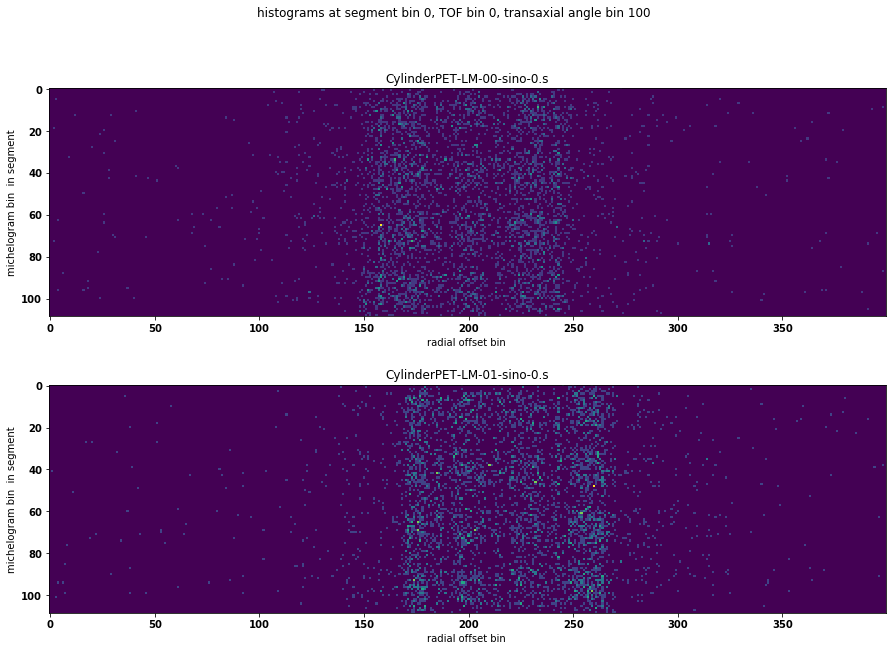

In [11]:
histogramDirectionView(segment_index=0, transaxial_angle=100, tof=0)

In [12]:
seg_widget = widgets.IntSlider(min=0, max=len(Utility.SEGMENT_TABLE)-1,description='segment bin',continuous_update=False)
tx_widget = widgets.IntSlider(min=0, max=Utility.NUMBER_OF_VIEWS-1,description=Utility.DIM_TITLES[2],continuous_update=False)
tof_widget = widgets.IntSlider(min=0, max = len(Utility.TOF_OFFSET_MAP)-1, description=Utility.DIM_TITLES[0], continuous_update=False)
interact(histogramDirectionView, segment_index=seg_widget, transaxial_angle=tx_widget, tof=tof_widget,bSaveFile=False);

AttributeError: module 'Utility' has no attribute 'DIM_TITLES'

In [ ]:
print()
mi_tup = np.nonzero(Utility.AXIAL_INDEX_MAP[Utility.SEGMENT_INDEX_MAP == 8] == 54)
print(mi_tup)
print(mi_tup[0][0])

In [ ]:
#look at "orthogonal sinograms (axial offset, tilt)" indexed by ro, tx
def orthogonalSinogramPlot(ro,tx,bSaveFile=False):
    
    shape = (len(Utility.SEGMENT_TABLE), Utility.SEGMENT_TABLE[0])
    plot_scale = 3
    plt.figure(figsize=(plot_scale*len(sino_paths)*4,plot_scale))
    tof = 0
    for k in range(0, len(sino_paths)):
        plt.subplot(1,len(sino_paths),k+1)
        o_sinogram = np.ones(shape, dtype=np.ushort)
        o_sinogram = o_sinogram*15
        data = sinogram_4D[k][tof,:,tx,ro]
        o_sinogram[Utility.SEGMENT_OFFSET_MAP[Utility.SEGMENT_INDEX_MAP]+4, Utility.AXIAL_INDEX_MAP] = data
        
        plt.imshow(o_sinogram)
        plt.xlabel("axial offset bin")
        plt.ylabel("ring difference bin")
        plt.title(sino_paths[k].split('/')[-1] 
                  )
    plt.suptitle(" orthogonal sinograms at " +
                  Utility.DIM_TITLES[2] + str(tx) + ", " + 
                  Utility.DIM_TITLES[3] + str(ro))
    if bSaveFile:
        img_folder = r"C:/Users/petct/Desktop/Hugo/Code/KEX_LM/img/"
        img_str = sino_paths[0].split('/')[-1].split('PET')[0] + "OrthoSinoAt" + "TOF" + str(tof) +"txAngle" + str(tx) + "ro"+str(ro)
        plt.savefig(fname=img_folder+img_str)
        print("figure saved to " + img_folder + img_str)
        
    plt.show()

    #print("axial index=", Utility.AXIAL_INDEX_MAP[mi])
    #print("segment offset=", Utility.SEGMENT_OFFSET_MAP[Utility.SEGMENT_INDEX_MAP[mi]]


In [ ]:
#kanyl is interesting at ro=200, tx = 0,167 and ro=275,tx = 70:100
ro_widget = widgets.IntSlider(min=0, max=Utility.NUMBER_OF_PROJECTIONS-1, description = Utility.DIM_TITLES[3])
tx_widget=widgets.IntSlider(min=0, max=Utility.NUMBER_OF_VIEWS-1, description=Utility.DIM_TITLES[2])

interact(orthogonalSinogramPlot, ro=ro_widget, tx=tx_widget);

In [ ]:
#CenterOfMass = Utility.CenterOfMassMultiplication(sinogram_4D, axis=(1,2,3,4))

In [ ]:
#print(CenterOfMass)

In [ ]:
#what happens if we let the direction vary?
tx_widget = widgets.IntSlider(0,Utility.NUMBER_OF_VIEWS)
segment_slider = widgets.IntSlider(0, Utility.NUMBER_OF_SEGMENTS)
ro_widget = widget.IntSlider(0, Utility.NUMBER_OF_PROJECTIONS)
tof_widget = widget.IntSlider(0, Utility.NUMBER_OF_TOFBINS)
ao_slider = widget.IntSlider(0, Utility.SEGMENT_TABLE[0])

view = np.zeros((Utility.NUMBER_OF_SEGMENTS, Utility.NUMBER_OF_VIEWS))

def f(tof, ao, ro):
    
    
    data = sinogram_4D[tof,Utility.,ro]
    
    view[]

In [8]:
import numpy as np
A = np.array([1,2,3])
B = [4,5,11]
B*A

array([ 4, 10, 33])